<a href="https://colab.research.google.com/github/Saputoa21/Machine-Translation/blob/main/Kopie_von_toy_lstm_pytorch_binaryclassifier_BasicsMT2025s.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [104]:
#import libraries
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline

#uncomment for reproducibility
#torch.manual_seed(42)
#import numpy as np
#np.random.seed(42)

# create data with positive instances (X2, Y2) and negative (X1, Y1)
#[N, T, F] number of instances, time, features
X1 = torch.randn(500, 2000, 100)
X2 = torch.randn(500, 2000, 100) + 1.5
X = torch.cat([X1, X2], dim=0)
Y1 = torch.zeros(500, 1)
Y2 = torch.ones(500, 1)
Y = torch.cat([Y1, Y2], dim=0)
#[N, F] instances, time, features
print(X.size())
#[N, 1] instances, label [0,1]
print(Y.size())

torch.Size([1000, 2000, 100])
torch.Size([1000, 1])


In [111]:
# parameers for LSTM in Pytorch
#torch.nn.LSTM(input_size, hidden_size, num_layers=1, bias=True, batch_first=False, dropout=0.0, bidirectional=False, proj_size=0, device=None, dtype=None

#define model
class Net(nn.Module):

    def __init__(self, feat_size=100, hidden_size=100, num_labels=1, dropout=0.2, bidirectional=False, feat_representation='mean'):
      super().__init__()
      self.feat_representation = feat_representation
      self.bidirectional = bidirectional
      self.fc1 = nn.Linear(feat_size, feat_size)
      self.relu = nn.ReLU()
      self.dout = nn.Dropout(dropout)
      self.lstm = nn.LSTM(feat_size, hidden_size, batch_first=True,
                          bidirectional=bidirectional)
      encoding_size = hidden_size * 2 if bidirectional else hidden_size
      self.fc2 = nn.Linear(encoding_size, hidden_size)
      self.out = nn.Linear(hidden_size, num_labels)
      self.out_act = nn.Sigmoid()

    def forward(self, x):
      #[B, T, F] batch, time, features
      h1 = self.fc1(x)
      h1 = self.relu(h1)
      # [B, T, H] batch, time, hidden or hidden * 2
      outputs, (final, _) = self.lstm(h1) #mke gru!!

      if self.feat_representation == 'mean':
        # mean over hidden states of LSTM
        outputs = self.dout(outputs)
        h = self.relu(self.fc2(outputs))
        #[B, H]
        h = h.mean(dim=1)
      elif self.feat_representation == 'last_state':
        # last hidden state of the lstm or concat of bidirectional forward and backward states
        if self.bidirectional:
            h_T_fwd = final[0]
            h_T_bwd = final[1]
            h = torch.cat([h_T_fwd, h_T_bwd], dim=-1)
        else:
            h = final[-1]
        h = self.relu(self.fc2(h))
        h = self.dout(h)
      #[B, 1]
      logits = self.out(h)
      probs = self.out_act(logits)
      return logits, probs

# model
model = Net()
#check for device
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device)
#print architecture
print(model)
#define adam optimizer
opt = optim.Adam(model.parameters(), lr=1e-3)
#define binary loss
criterion = nn.BCEWithLogitsLoss()

# parameters for BCELoss
# torch.nn.BCELoss(weight=None, size_average=None, reduce=None, reduction='mean')

Net(
  (fc1): Linear(in_features=100, out_features=100, bias=True)
  (relu): ReLU()
  (dout): Dropout(p=0.2, inplace=False)
  (lstm): LSTM(100, 100, batch_first=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (out): Linear(in_features=100, out_features=1, bias=True)
  (out_act): Sigmoid()
)


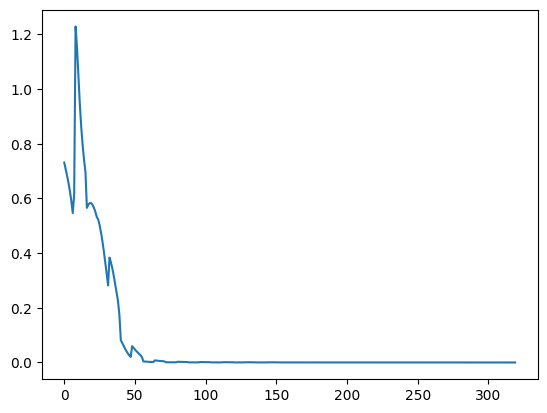

In [112]:
#define hyperparameters
e_losses = []
e_losses_per_epoch = []
num_epochs = 20
batch_size=64

for e in range(num_epochs):
  model.train()
  loss_batch = []
  for beg_i in range(0, X.size(0), batch_size):
    #batch instances given batch size
    x_batch = X[beg_i:beg_i + batch_size, :]
    y_batch = Y[beg_i:beg_i + batch_size, :]
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    opt.zero_grad()
    # (1) Forward
    y_logits, y_probs = model(x_batch)
    #print(y_probs.size())
    # (2) Compute loss
    loss = criterion(y_logits, y_batch)
    #save loss of batch
    loss_batch.append(loss.item())
    # (3) Compute gradients
    loss.backward()
    #print('backprop')
    # (4) update weights
    opt.step()

  e_losses += loss_batch

  # calculate the average loss for the current epoch
  average_loss_per_epoch = sum(loss_batch) / len(loss_batch)
  e_losses_per_epoch.append(average_loss_per_epoch)

#plot loss over epochs
plt.plot(e_losses)
plt.xlabel("Number of e-loss")
plt.ylabel("e-loss value")
plt.title("Loss across bataches")

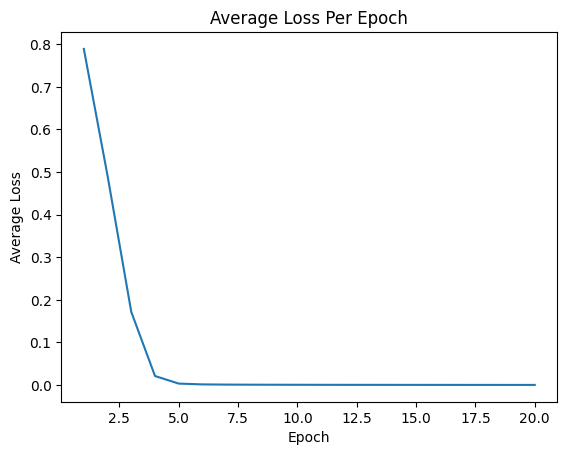

In [113]:
# plot loss over epochs
plt.plot(range(1, num_epochs + 1), e_losses_per_epoch)
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Average Loss Per Epoch")
plt.show()

In [114]:
print(len(e_losses))

320


In [115]:
print(len(loss_batch))

16


In [116]:
#prediction
x_t = torch.randn(1, 2000, 100)
x_t = x_t.to(device)

model.eval()
y_logit, y_prob = model(x_t)
print(y_prob.item())
x_1_t = torch.randn(1, 200, 100) + 1.5
x_1_t = x_1_t.to(device)
y1_logit, y1_prob = model(x_1_t)
print(y1_prob.item())

0.00017731619300320745
0.9999299049377441


# TODO

Make a new section for each new model NetLast(), NetBiLSTM(), NetDropout()....

- Try different feature representations: last state and bidirectional LSTM
- try different feature sizes, and dropout [0.1, 0.5, 0.8]
- try different non linearities: sigmod, tanh
- Use a GRU instead of LSTM: [GRU pytorch](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html)
- what if we predict a sequence instead of classification?
```python
#[N, T, F] number of instances, time, features
X1 = torch.randn(1000, 48, 50)
X2 = torch.randn(1000, 48, 50) + 1.5
X = torch.cat([X1, X2], dim=0)
mask = torch.cuda.FloatTensor(2000, 48, 1).uniform_() > 0.8
Y1 = torch.zeros(1000, 1)
Y2 = torch.ones(1000, 1)
#[B, 1]
Y_mean = torch.cat([Y1, Y2], dim=0)
#[B, T, 1]
Y_seq = Y_mean.unsqueeze(1).repeat(1, 48, 1)
#[N, F] instances, time, features
print(X.size())
#[N, 1] instances, label [0,1]
print(Y_seq.size())
#print(Y_mean.size())
print(mask.size())
#in model
def forward(self, x):
    #...
    #[B, T, H]
    #h_mean = h_time.mean(1)
    #[B, T, H] logits is a seq
    #logits_mean = self.out_mean(h_mean)
    return logits_seq
#criterion
criterion = nn.BCEWithLogitsLoss(reduction='none')
#[B, 1] mean (0)
#loss
#[B, T, 1]
loss_seq = loss_seq * x_mask
loss_seq = loss_seq.sum(1)
loss_seq = loss_seq.mean(0)
```
- change BCElogits to probs https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html


## Model 1: Last state

In [117]:
# model
model = Net()
model.feat_representation = 'last_state'
print(model.feat_representation)

#check for device
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device)

#define adam optimizer
opt = optim.Adam(model.parameters(), lr=1e-3)

#define binary loss
criterion = nn.BCEWithLogitsLoss()

last_state


Text(0.5, 1.0, 'Loss across bataches')

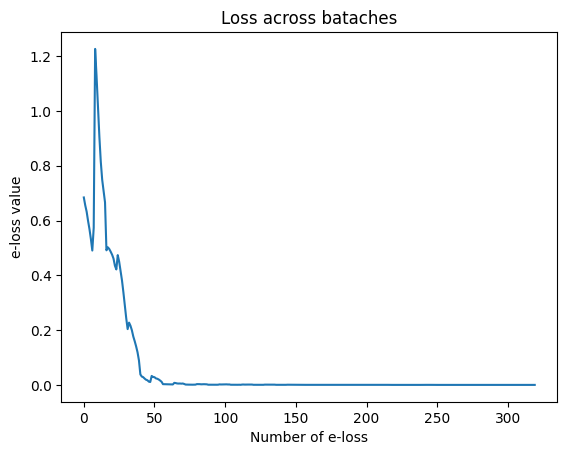

In [118]:
#define hyperparameters
e_losses = []
e_losses_per_epoch = []
num_epochs = 20
batch_size=64

for e in range(num_epochs):
  model.train()
  loss_batch = []
  for beg_i in range(0, X.size(0), batch_size):
    #batch instances given batch size
    x_batch = X[beg_i:beg_i + batch_size, :]
    y_batch = Y[beg_i:beg_i + batch_size, :]
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    opt.zero_grad()
    # (1) Forward
    y_logits, y_probs = model(x_batch)
    #print(y_probs.size())
    # (2) Compute loss
    loss = criterion(y_logits, y_batch)
    #save loss of batch
    loss_batch.append(loss.item())
    # (3) Compute gradients
    loss.backward()
    #print('backprop')
    # (4) update weights
    opt.step()

  e_losses += loss_batch

  # calculate the average loss for the current epoch
  average_loss_per_epoch = sum(loss_batch) / len(loss_batch)
  e_losses_per_epoch.append(average_loss_per_epoch)

#plot loss over epochs
plt.plot(e_losses)
plt.xlabel("Number of e-loss")
plt.ylabel("e-loss value")
plt.title("Loss across batches")

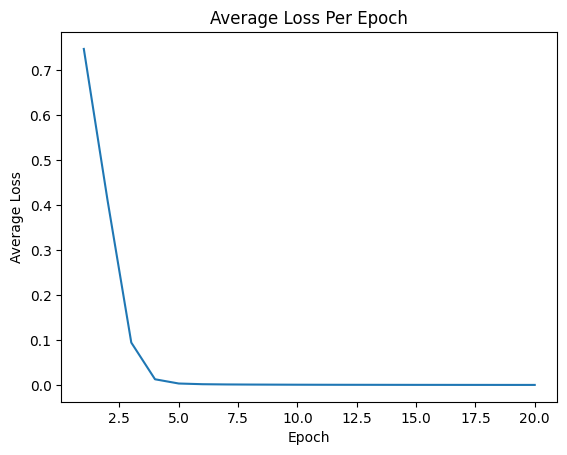

In [119]:
# plot loss over epochs
plt.plot(range(1, num_epochs + 1), e_losses_per_epoch)
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Average Loss Per Epoch")
plt.show()

In [120]:
#prediction
x_t = torch.randn(1, 2000, 100)
x_t = x_t.to(device)

model.eval()
y_logit, y_prob = model(x_t)
print(y_prob.item())
x_1_t = torch.randn(1, 200, 100) + 1.5
x_1_t = x_1_t.to(device)
y1_logit, y1_prob = model(x_1_t)
print(y1_prob.item())

0.00016125892580021173
0.9999070167541504


## Model 2: Bidirectional

In [121]:
# model
model = Net()
model.bidirectional = 'True'
print(model.bidirectional)

#check for device
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device)

#define adam optimizer
opt = optim.Adam(model.parameters(), lr=1e-3)

#define binary loss
criterion = nn.BCEWithLogitsLoss()

True


Text(0.5, 1.0, 'Loss across batches')

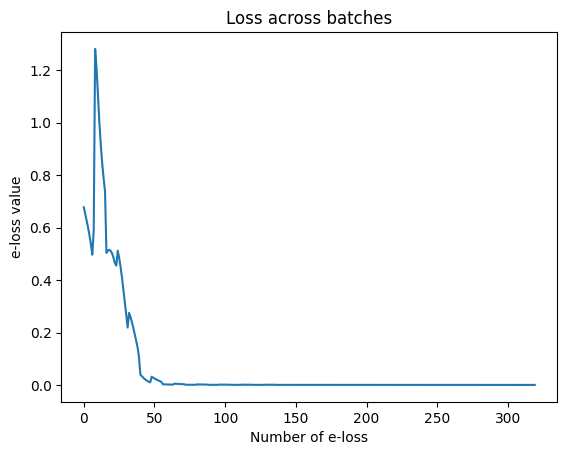

In [122]:
#define hyperparameters
e_losses = []
e_losses_per_epoch = []
num_epochs = 20
batch_size=64

for e in range(num_epochs):
  model.train()
  loss_batch = []
  for beg_i in range(0, X.size(0), batch_size):
    #batch instances given batch size
    x_batch = X[beg_i:beg_i + batch_size, :]
    y_batch = Y[beg_i:beg_i + batch_size, :]
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    opt.zero_grad()
    # (1) Forward
    y_logits, y_probs = model(x_batch)
    #print(y_probs.size())
    # (2) Compute loss
    loss = criterion(y_logits, y_batch)
    #save loss of batch
    loss_batch.append(loss.item())
    # (3) Compute gradients
    loss.backward()
    #print('backprop')
    # (4) update weights
    opt.step()

  e_losses += loss_batch

  # calculate the average loss for the current epoch
  average_loss_per_epoch = sum(loss_batch) / len(loss_batch)
  e_losses_per_epoch.append(average_loss_per_epoch)

#plot loss over epochs
plt.plot(e_losses)
plt.xlabel("Number of e-loss")
plt.ylabel("e-loss value")
plt.title("Loss across batches")

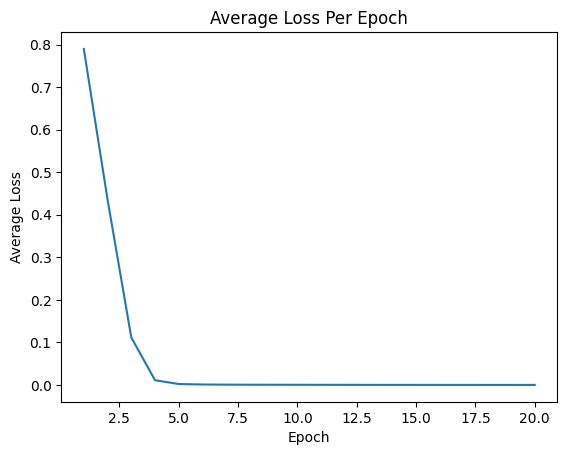

In [123]:
# plot loss over epochs
plt.plot(range(1, num_epochs + 1), e_losses_per_epoch)
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Average Loss Per Epoch")
plt.show()

In [124]:
#prediction
x_t = torch.randn(1, 2000, 100)
x_t = x_t.to(device)

model.eval()
y_logit, y_prob = model(x_t)
print(y_prob.item())
x_1_t = torch.randn(1, 200, 100) + 1.5
x_1_t = x_1_t.to(device)
y1_logit, y1_prob = model(x_1_t)
print(y1_prob.item())

0.0001333738473476842
0.9999532699584961


## Model 3: Dropout 0.1

In [126]:
# model
model = Net()
model.dout = nn.Dropout(0.1)
print(model.dout)

#check for device
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device)

#define adam optimizer
opt = optim.Adam(model.parameters(), lr=1e-3)

#define binary loss
criterion = nn.BCEWithLogitsLoss()

Dropout(p=0.1, inplace=False)
Net(
  (fc1): Linear(in_features=100, out_features=100, bias=True)
  (relu): ReLU()
  (dout): Dropout(p=0.1, inplace=False)
  (lstm): LSTM(100, 100, batch_first=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (out): Linear(in_features=100, out_features=1, bias=True)
  (out_act): Sigmoid()
)


Text(0.5, 1.0, 'Loss across batches')

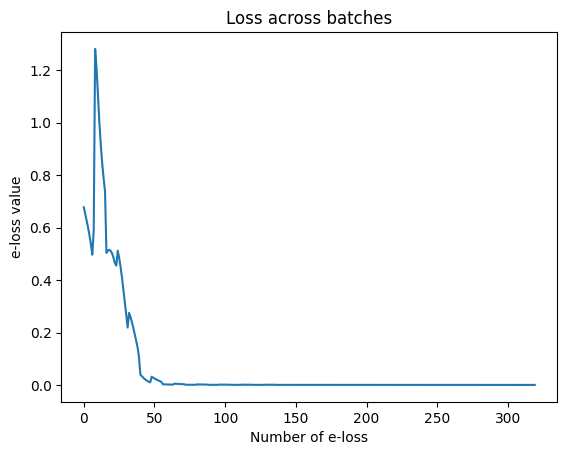

In [ ]:
#define hyperparameters
e_losses = []
e_losses_per_epoch = []
num_epochs = 20
batch_size=64

for e in range(num_epochs):
  model.train()
  loss_batch = []
  for beg_i in range(0, X.size(0), batch_size):
    #batch instances given batch size
    x_batch = X[beg_i:beg_i + batch_size, :]
    y_batch = Y[beg_i:beg_i + batch_size, :]
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)
    opt.zero_grad()
    # (1) Forward
    y_logits, y_probs = model(x_batch)
    #print(y_probs.size())
    # (2) Compute loss
    loss = criterion(y_logits, y_batch)
    #save loss of batch
    loss_batch.append(loss.item())
    # (3) Compute gradients
    loss.backward()
    #print('backprop')
    # (4) update weights
    opt.step()

  e_losses += loss_batch

  # calculate the average loss for the current epoch
  average_loss_per_epoch = sum(loss_batch) / len(loss_batch)
  e_losses_per_epoch.append(average_loss_per_epoch)

#plot loss over epochs
plt.plot(e_losses)
plt.xlabel("Number of e-loss")
plt.ylabel("e-loss value")
plt.title("Loss across batches")

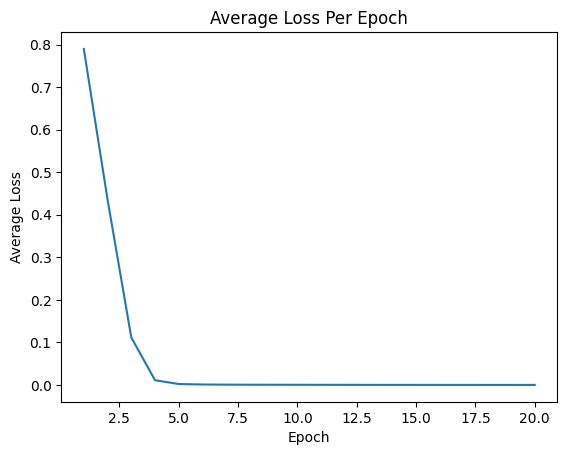

In [ ]:
# plot loss over epochs
plt.plot(range(1, num_epochs + 1), e_losses_per_epoch)
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Average Loss Per Epoch")
plt.show()

In [ ]:
#prediction
x_t = torch.randn(1, 2000, 100)
x_t = x_t.to(device)

model.eval()
y_logit, y_prob = model(x_t)
print(y_prob.item())
x_1_t = torch.randn(1, 200, 100) + 1.5
x_1_t = x_1_t.to(device)
y1_logit, y1_prob = model(x_1_t)
print(y1_prob.item())

0.0001333738473476842
0.9999532699584961


## Model 4: Dropout 0.5

In [ ]:
# model
model = Net
model.dout =  nn.Dropout(0.5)

#check for device
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device)

#define adam optimizer
opt = optim.Adam(model.parameters(), lr=1e-3)

#define binary loss
criterion = nn.BCEWithLogitsLoss()

Text(0.5, 1.0, 'Loss across batches')

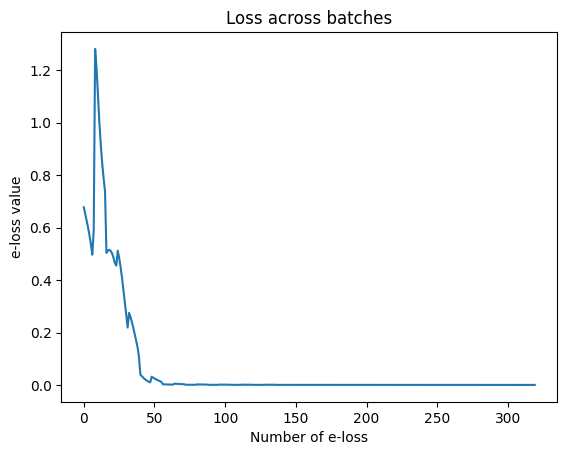

In [ ]:
#define hyperparameters
e_losses = []
e_losses_per_epoch = []
num_epochs = 20
batch_size=64

for e in range(num_epochs):
  model.train()
  loss_batch = []
  for beg_i in range(0, X.size(0), batch_size):
    #batch instances given batch size
    x_batch = X[beg_i:beg_i + batch_size, :]
    y_batch = Y[beg_i:beg_i + batch_size, :]
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    opt.zero_grad()
    # (1) Forward
    y_logits, y_probs = model(x_batch)
    #print(y_probs.size())
    # (2) Compute loss
    loss = criterion(y_logits, y_batch)
    #save loss of batch
    loss_batch.append(loss.item())
    # (3) Compute gradients
    loss.backward()
    #print('backprop')
    # (4) update weights
    opt.step()

  e_losses += loss_batch

  # calculate the average loss for the current epoch
  average_loss_per_epoch = sum(loss_batch) / len(loss_batch)
  e_losses_per_epoch.append(average_loss_per_epoch)

#plot loss over epochs
plt.plot(e_losses)
plt.xlabel("Number of e-loss")
plt.ylabel("e-loss value")
plt.title("Loss across batches")

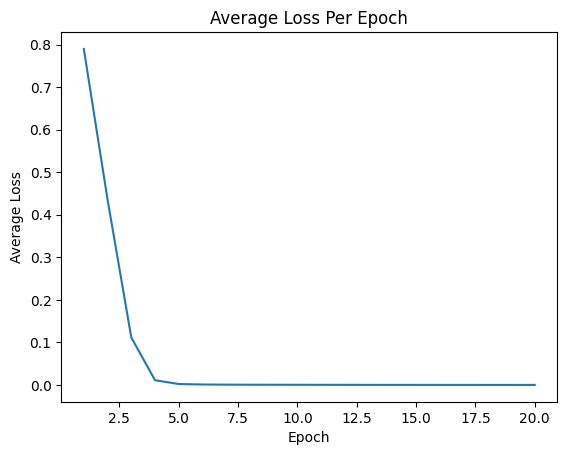

In [ ]:
# plot loss over epochs
plt.plot(range(1, num_epochs + 1), e_losses_per_epoch)
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Average Loss Per Epoch")
plt.show()

In [ ]:
#prediction
x_t = torch.randn(1, 2000, 100)
x_t = x_t.to(device)

model.eval()
y_logit, y_prob = model(x_t)
print(y_prob.item())
x_1_t = torch.randn(1, 200, 100) + 1.5
x_1_t = x_1_t.to(device)
y1_logit, y1_prob = model(x_1_t)
print(y1_prob.item())

0.0001333738473476842
0.9999532699584961


## Model 5: Dropout 0.8

In [ ]:
# model
model = Net()
model.dout = nn.Dropout(0.8)
print(model.dout)

#check for device
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device)

#define adam optimizer
opt = optim.Adam(model.parameters(), lr=1e-3)

#define binary loss
criterion = nn.BCEWithLogitsLoss()

Text(0.5, 1.0, 'Loss across batches')

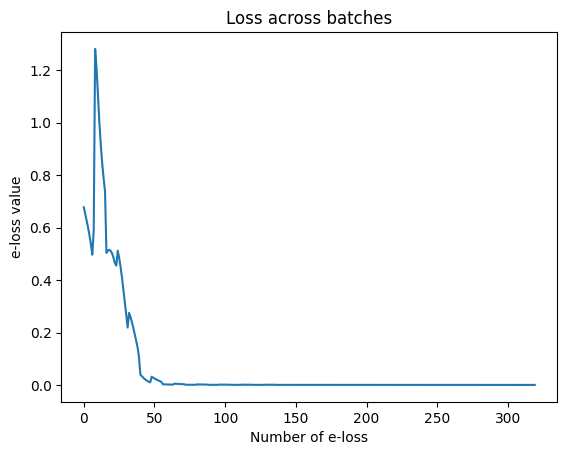

In [ ]:
#define hyperparameters
e_losses = []
e_losses_per_epoch = []
num_epochs = 20
batch_size=64

for e in range(num_epochs):
  model.train()
  loss_batch = []
  for beg_i in range(0, X.size(0), batch_size):
    #batch instances given batch size
    x_batch = X[beg_i:beg_i + batch_size, :]
    y_batch = Y[beg_i:beg_i + batch_size, :]
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    opt.zero_grad()
    # (1) Forward
    y_logits, y_probs = model(x_batch)
    #print(y_probs.size())
    # (2) Compute loss
    loss = criterion(y_logits, y_batch)
    #save loss of batch
    loss_batch.append(loss.item())
    # (3) Compute gradients
    loss.backward()
    #print('backprop')
    # (4) update weights
    opt.step()

  e_losses += loss_batch

  # calculate the average loss for the current epoch
  average_loss_per_epoch = sum(loss_batch) / len(loss_batch)
  e_losses_per_epoch.append(average_loss_per_epoch)

#plot loss over epochs
plt.plot(e_losses)
plt.xlabel("Number of e-loss")
plt.ylabel("e-loss value")
plt.title("Loss across batches")

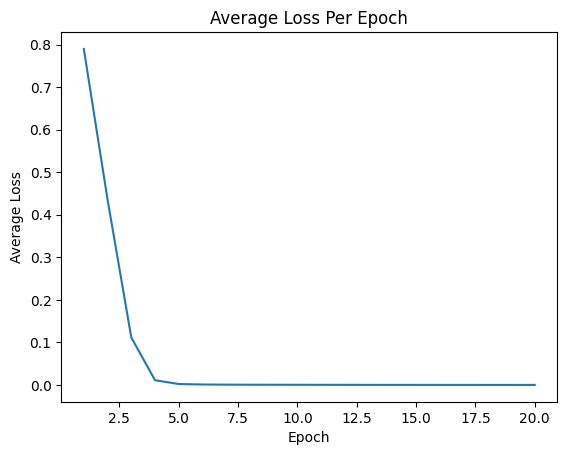

In [ ]:
# plot loss over epochs
plt.plot(range(1, num_epochs + 1), e_losses_per_epoch)
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Average Loss Per Epoch")
plt.show()

In [ ]:
#prediction
x_t = torch.randn(1, 2000, 100)
x_t = x_t.to(device)

model.eval()
y_logit, y_prob = model(x_t)
print(y_prob.item())
x_1_t = torch.randn(1, 200, 100) + 1.5
x_1_t = x_1_t.to(device)
y1_logit, y1_prob = model(x_1_t)
print(y1_prob.item())

0.0001333738473476842
0.9999532699584961


## Model 6: Non-linearity with sigmoid

In [131]:
#define model
class Net_sigm(nn.Module):

    def __init__(self, feat_size=100, hidden_size=100, num_labels=1, dropout=0.2, bidirectional=False, feat_representation='mean'):
      super().__init__()
      self.feat_representation = feat_representation
      self.bidirectional = bidirectional
      self.fc1 = nn.Linear(feat_size, feat_size)
      self.sigm = nn.Sigmoid()
      self.dout = nn.Dropout(dropout)
      self.lstm = nn.LSTM(feat_size, hidden_size, batch_first=True,
                          bidirectional=bidirectional)
      encoding_size = hidden_size * 2 if bidirectional else hidden_size
      self.fc2 = nn.Linear(encoding_size, hidden_size)
      self.out = nn.Linear(hidden_size, num_labels)
      self.out_act = nn.Sigmoid()

    def forward(self, x):
      #[B, T, F] batch, time, features
      h1 = self.fc1(x)
      h1 = self.relu(h1)
      # [B, T, H] batch, time, hidden or hidden * 2
      outputs, (final, _) = self.lstm(h1) #mke gru!!

      if self.feat_representation == 'mean':
        # mean over hidden states of LSTM
        outputs = self.dout(outputs)
        h = self.relu(self.fc2(outputs))
        #[B, H]
        h = h.mean(dim=1)
      elif self.feat_representation == 'last_state':
        # last hidden state of the lstm or concat of bidirectional forward and backward states
        if self.bidirectional:
            h_T_fwd = final[0]
            h_T_bwd = final[1]
            h = torch.cat([h_T_fwd, h_T_bwd], dim=-1)
        else:
            h = final[-1]
        h = self.relu(self.fc2(h))
        h = self.dout(h)
      #[B, 1]
      logits = self.out(h)
      probs = self.out_act(logits)
      return logits, probs

# model
model = Net_sigm()

#check for device
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device)

#print architecture
print(model)

#define adam optimizer
opt = optim.Adam(model.parameters(), lr=1e-3)

#define binary loss
criterion = nn.BCEWithLogitsLoss()

Net_sigm(
  (fc1): Linear(in_features=100, out_features=100, bias=True)
  (sigm): Sigmoid()
  (dout): Dropout(p=0.2, inplace=False)
  (lstm): LSTM(100, 100, batch_first=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (out): Linear(in_features=100, out_features=1, bias=True)
  (out_act): Sigmoid()
)


Text(0.5, 1.0, 'Loss across batches')

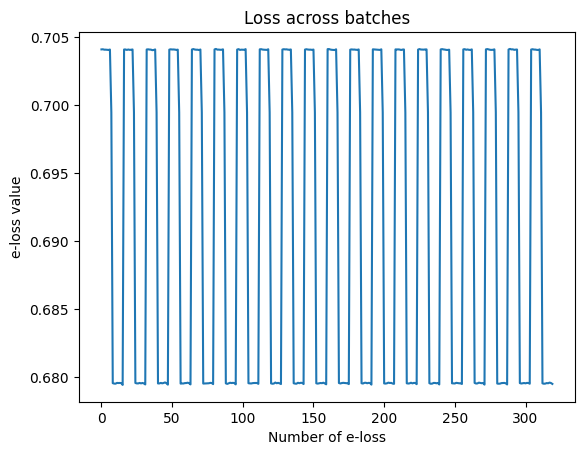

In [134]:
#define hyperparameters
e_losses = []
e_losses_per_epoch = []
num_epochs = 20
batch_size=64

for e in range(num_epochs):
  model.train()
  loss_batch = []
  for beg_i in range(0, X.size(0), batch_size):
    #batch instances given batch size
    x_batch = X[beg_i:beg_i + batch_size, :]
    y_batch = Y[beg_i:beg_i + batch_size, :]
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)
    opt.zero_grad()
    # (1) Forward
    y_logits, y_probs = model(x_batch)
    #print(y_probs.size())
    # (2) Compute loss
    loss = criterion(y_logits, y_batch)
    #save loss of batch
    loss_batch.append(loss.item())
    # (3) Compute gradients
    loss.backward()
    #print('backprop')
    # (4) update weights
    opt.step()

  e_losses += loss_batch

  # calculate the average loss for the current epoch
  average_loss_per_epoch = sum(loss_batch) / len(loss_batch)
  e_losses_per_epoch.append(average_loss_per_epoch)

#plot loss over epochs
plt.plot(e_losses)
plt.xlabel("Number of e-loss")
plt.ylabel("e-loss value")
plt.title("Loss across batches")

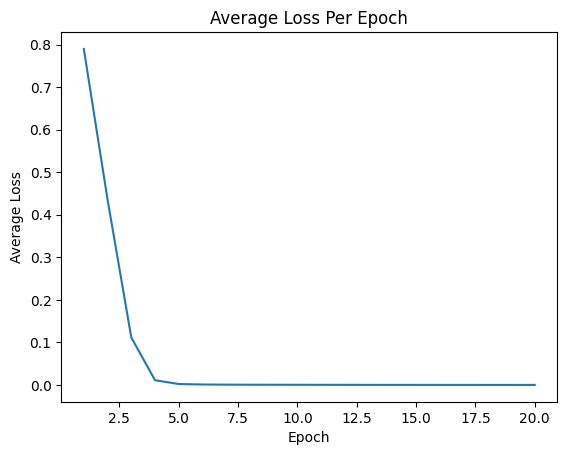

In [ ]:
# plot loss over epochs
plt.plot(range(1, num_epochs + 1), e_losses_per_epoch)
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Average Loss Per Epoch")
plt.show()

In [ ]:
#prediction
x_t = torch.randn(1, 2000, 100)
x_t = x_t.to(device)

model.eval()
y_logit, y_prob = model(x_t)
print(y_prob.item())
x_1_t = torch.randn(1, 200, 100) + 1.5
x_1_t = x_1_t.to(device)
y1_logit, y1_prob = model(x_1_t)
print(y1_prob.item())

0.0001333738473476842
0.9999532699584961


## Model 7: Non-linearity with tanh

In [129]:
#define model
class Net_tanh(nn.Module):

    def __init__(self, feat_size=100, hidden_size=100, num_labels=1, dropout=0.2, bidirectional=False, feat_representation='mean'):
      super().__init__()
      self.feat_representation = feat_representation
      self.bidirectional = bidirectional
      self.fc1 = nn.Linear(feat_size, feat_size)
      self.tanh = nn.Tanh()
      self.dout = nn.Dropout(dropout)
      self.lstm = nn.LSTM(feat_size, hidden_size, batch_first=True,
                          bidirectional=bidirectional)
      encoding_size = hidden_size * 2 if bidirectional else hidden_size
      self.fc2 = nn.Linear(encoding_size, hidden_size)
      self.out = nn.Linear(hidden_size, num_labels)
      self.out_act = nn.Sigmoid()

    def forward(self, x):
      #[B, T, F] batch, time, features
      h1 = self.fc1(x)
      h1 = self.relu(h1)
      # [B, T, H] batch, time, hidden or hidden * 2
      outputs, (final, _) = self.lstm(h1) #mke gru!!

      if self.feat_representation == 'mean':
        # mean over hidden states of LSTM
        outputs = self.dout(outputs)
        h = self.relu(self.fc2(outputs))
        #[B, H]
        h = h.mean(dim=1)
      elif self.feat_representation == 'last_state':
        # last hidden state of the lstm or concat of bidirectional forward and backward states
        if self.bidirectional:
            h_T_fwd = final[0]
            h_T_bwd = final[1]
            h = torch.cat([h_T_fwd, h_T_bwd], dim=-1)
        else:
            h = final[-1]
        h = self.relu(self.fc2(h))
        h = self.dout(h)
      #[B, 1]
      logits = self.out(h)
      probs = self.out_act(logits)
      return logits, probs

# model
model = Net_tanh()

#check for device
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device)

#print architecture
print(model)

#define adam optimizer
opt = optim.Adam(model.parameters(), lr=1e-3)

#define binary loss
criterion = nn.BCEWithLogitsLoss()

Net_tanh(
  (fc1): Linear(in_features=100, out_features=100, bias=True)
  (tanh): Tanh()
  (dout): Dropout(p=0.2, inplace=False)
  (lstm): LSTM(100, 100, batch_first=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (out): Linear(in_features=100, out_features=1, bias=True)
  (out_act): Sigmoid()
)


Text(0.5, 1.0, 'Loss across batches')

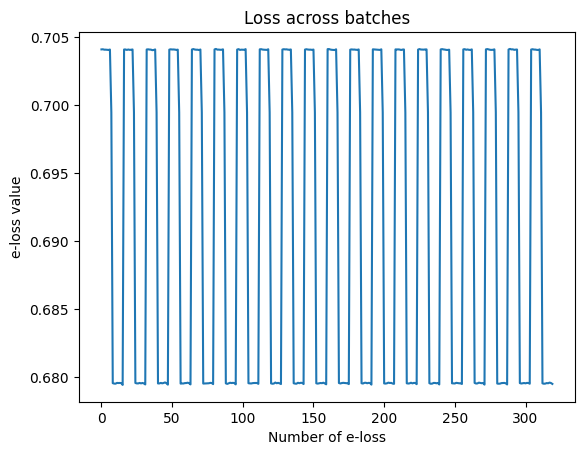

In [ ]:
#define hyperparameters
e_losses = []
e_losses_per_epoch = []
num_epochs = 20
batch_size=64

for e in range(num_epochs):
  model.train()
  loss_batch = []
  for beg_i in range(0, X.size(0), batch_size):
    #batch instances given batch size
    x_batch = X[beg_i:beg_i + batch_size, :]
    y_batch = Y[beg_i:beg_i + batch_size, :]
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)
    opt.zero_grad()
    # (1) Forward
    y_logits, y_probs = model(x_batch)
    #print(y_probs.size())
    # (2) Compute loss
    loss = criterion(y_logits, y_batch)
    #save loss of batch
    loss_batch.append(loss.item())
    # (3) Compute gradients
    loss.backward()
    #print('backprop')
    # (4) update weights
    opt.step()

  e_losses += loss_batch

  # calculate the average loss for the current epoch
  average_loss_per_epoch = sum(loss_batch) / len(loss_batch)
  e_losses_per_epoch.append(average_loss_per_epoch)

#plot loss over epochs
plt.plot(e_losses)
plt.xlabel("Number of e-loss")
plt.ylabel("e-loss value")
plt.title("Loss across batches")

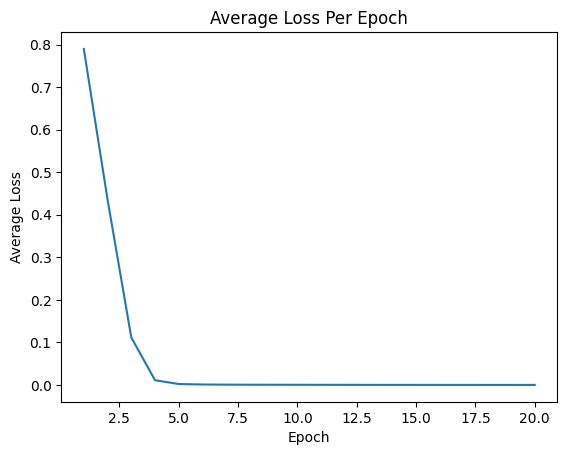

In [ ]:
# plot loss over epochs
plt.plot(range(1, num_epochs + 1), e_losses_per_epoch)
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Average Loss Per Epoch")
plt.show()

In [ ]:
#prediction
x_t = torch.randn(1, 2000, 100)
x_t = x_t.to(device)

model.eval()
y_logit, y_prob = model(x_t)
print(y_prob.item())
x_1_t = torch.randn(1, 200, 100) + 1.5
x_1_t = x_1_t.to(device)
y1_logit, y1_prob = model(x_1_t)
print(y1_prob.item())

0.0001333738473476842
0.9999532699584961


## Model 8: GRU

In [ ]:
# parameters for GRU in Pytorch
# torch.nn.GRU(input_size, hidden_size, num_layers=1, bias=True, batch_first=False, dropout=0.0, bidirectional=False, device=None, dtype=None)

#define model
class Net_GRU(nn.Module):

    def __init__(self, feat_size=100, hidden_size=100, num_labels=1, dropout=0.2, bidirectional=False, feat_representation='mean'):
      super().__init__()
      self.feat_representation = feat_representation
      self.bidirectional = bidirectional
      self.fc1 = nn.Linear(feat_size, feat_size)
      self.relu = nn.Relu()
      self.dout = nn.Dropout(dropout)
      self.gru = nn.GRU(feat_size, hidden_size, batch_first=True, #I put True as it was so also for LSTM model
                        bidirectional = bidirectional)
      encoding_size = hidden_size * 2 if bidirectional else hidden_size
      self.fc2 = nn.Linear(encoding_size, hidden_size)
      self.out = nn.Linear(hidden_size, num_labels)
      self.out_act = nn.Sigmoid()

    def forward(self, x):
      #[B, T, F] batch, time, features
      h1 = self.fc1(x)
      h1 = self.relu(h1)
      # [B, T, H] batch, time, hidden or hidden * 2
      outputs, (final, _) = self.gru(h1) #mke gru!!

      if self.feat_representation == 'mean':
        # mean over hidden states of GRU
        outputs = self.dout(outputs)
        h = self.relu(self.fc2(outputs))
        #[B, H]
        h = h.mean(dim=1)
      elif self.feat_representation == 'last_state':
        # last hidden state of the gru or concat of bidirectional forward and backward states
        if self.bidirectional:
            h_T_fwd = final[0]
            h_T_bwd = final[1]
            h = torch.cat([h_T_fwd, h_T_bwd], dim=-1)
        else:
            h = final[-1]
        h = self.relu(self.fc2(h))
        h = self.dout(h)
      #[B, 1]
      logits = self.out(h)
      probs = self.out_act(logits)
      return logits, probs

# model
model = Net_gru()

#check for device
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device)

#print architecture
print(model)

#define adam optimizer
opt = optim.Adam(model.parameters(), lr=1e-3)

#define binary loss
criterion = nn.BCEWithLogitsLoss()

Text(0.5, 1.0, 'Loss across batches')

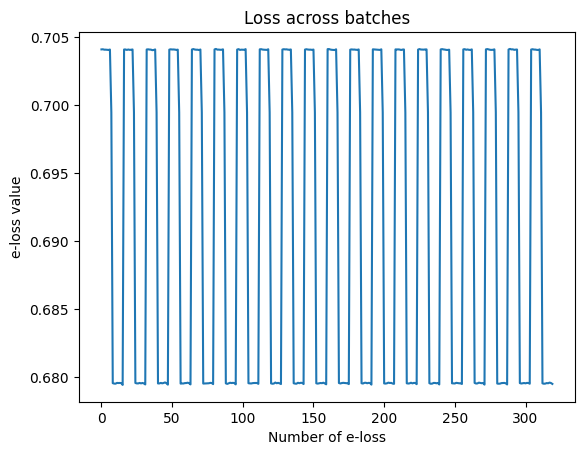

In [ ]:
#define hyperparameters
e_losses = []
e_losses_per_epoch = []
num_epochs = 20
batch_size=64

for e in range(num_epochs):
  model.train()
  loss_batch = []
  for beg_i in range(0, X.size(0), batch_size):
    #batch instances given batch size
    x_batch = X[beg_i:beg_i + batch_size, :]
    y_batch = Y[beg_i:beg_i + batch_size, :]
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)
    opt.zero_grad()
    # (1) Forward
    y_logits, y_probs = model(x_batch)
    #print(y_probs.size())
    # (2) Compute loss
    loss = criterion(y_logits, y_batch)
    #save loss of batch
    loss_batch.append(loss.item())
    # (3) Compute gradients
    loss.backward()
    #print('backprop')
    # (4) update weights
    opt.step()

  e_losses += loss_batch

  # calculate the average loss for the current epoch
  average_loss_per_epoch = sum(loss_batch) / len(loss_batch)
  e_losses_per_epoch.append(average_loss_per_epoch)

#plot loss over epochs
plt.plot(e_losses)
plt.xlabel("Number of e-loss")
plt.ylabel("e-loss value")
plt.title("Loss across batches")

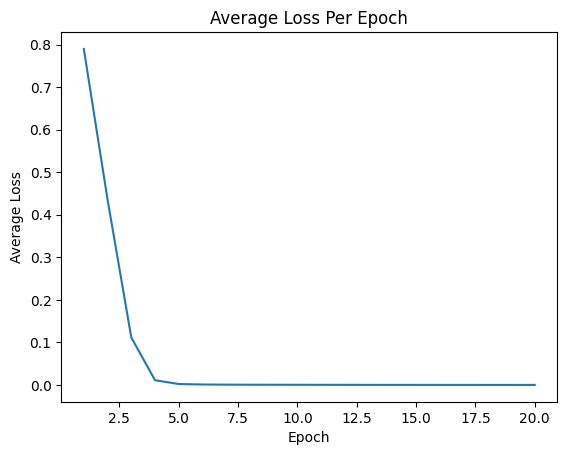

In [ ]:
# plot loss over epochs
plt.plot(range(1, num_epochs + 1), e_losses_per_epoch)
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Average Loss Per Epoch")
plt.show()

In [ ]:
#prediction
x_t = torch.randn(1, 2000, 100)
x_t = x_t.to(device)

model.eval()
y_logit, y_prob = model(x_t)
print(y_prob.item())
x_1_t = torch.randn(1, 200, 100) + 1.5
x_1_t = x_1_t.to(device)
y1_logit, y1_prob = model(x_1_t)
print(y1_prob.item())

0.0001333738473476842
0.9999532699584961


## Model 9: Prediciting a sequence

## Model 10: Different feature size

## Model 11: Probs instead of BCElogits